<a href="https://colab.research.google.com/github/Shashank-Ojha/WordFormer/blob/main/trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install torch
!pip install torchvision
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms

from utils.diffusion_model import DiffusionConfig
from utils.diffusion_model import DiffusionModel

from utils.diffusion_model import UNet

# Set a seed for reproducibility
torch.manual_seed(0)

In [20]:
# Define a transform to convert to images to tensor and normalize

transform = transforms.Compose([
    # Resize the input image so that the height and width are powers of 2.
    # This makes it easy for the UNET which divides/multiplies the height
    # width by 2 each step.
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # Mean and std have to be sequences (e.g. tuples). You are supposed
    # to provide the mean and std for each channel, but in our case we just
    # have 1 channel.
    # This normalizes the data such that:
    # --  output[channel] = (input[channel] - mean[channel]) / std[channel]
    transforms.Normalize((0.5,),(0.5,),) # Standardize assuming mean,var = 0.5
])


#
dataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)
image, label = dataset[0]

print(f"Size of dataset: {len(dataset)}")
print(f"Image Shape: {image.shape}")
print(f"Label: {label}")

labels = torch.tensor(dataset.targets)
unique_labels = torch.unique(labels)
print("Unique labels:", unique_labels)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Size of dataset: 10000
Image Shape: torch.Size([1, 32, 32])
Label: 9
Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


<ipython-input-20-74cb150fbbb4>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(dataset.targets)


In [21]:
# ------ Hyperparameters ------

# -- Data Breakdown
batch_size = 128

# -- Model Parameters
start_schedule = 0.001
end_schedule = 0.02
time_steps = 300

# -- Training Parameters
learning_rate = 0.0001
max_iters = 2000
eval_iters = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [22]:
# Let's break down the data into batches.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Now we should have the data in batch sizes of 64
for images, labels in dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 1, 32, 32])
torch.Size([128])


In [23]:
# We can repeatedly call this infintely to get a new batch
images, labels = next(iter(dataloader))

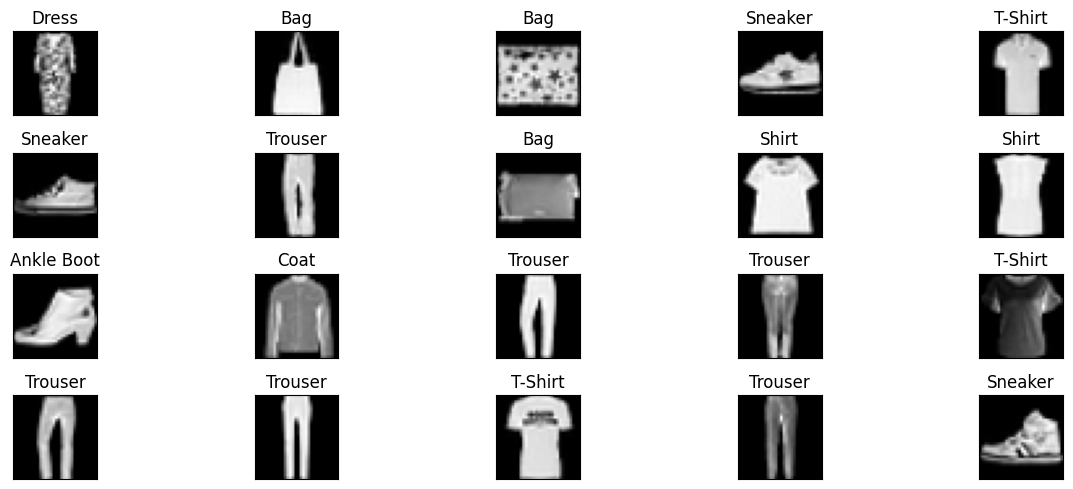

In [24]:
fig = plt.figure(figsize=(15,5))
for idx in np.arange(min(batch_size, 20)):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels_map[labels[idx].item()])
  fig.tight_layout()

In [25]:
# -- Define Network
config_dict = {
    'start_schedule': start_schedule,
    'end_schedule': end_schedule,
    'time_steps': time_steps,
}

config = DiffusionConfig(**config_dict)
model = DiffusionModel(config)
unet = UNet()

model = model.to(device)
unet = unet.to(device)

torch.Size([8, 1, 32, 32])
tensor([  0,  42,  85, 128, 170, 213, 256, 299], device='cuda:0')


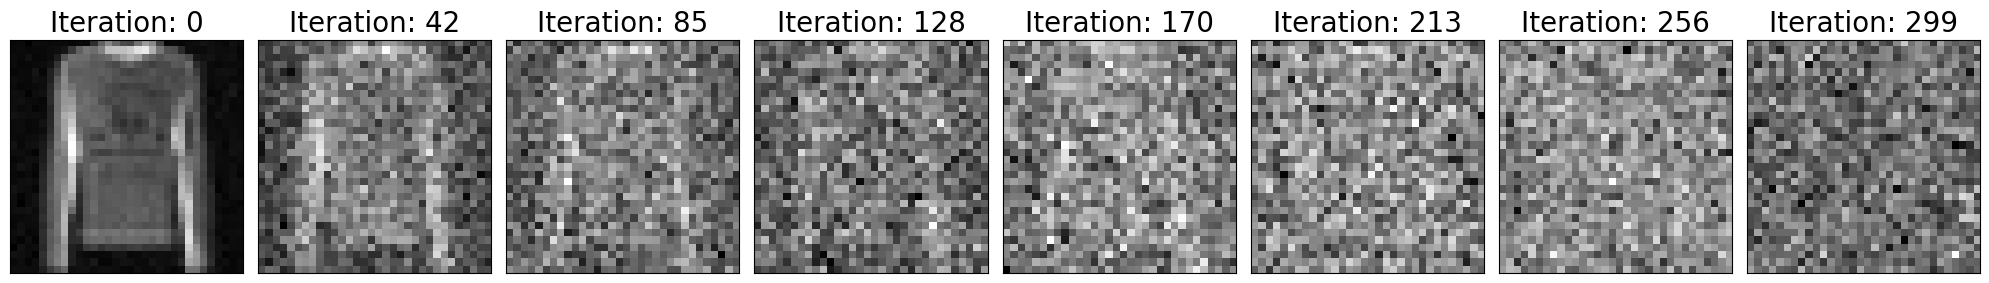

In [26]:
images, labels = next(iter(dataloader))

# Specify the number of images you want to display.
NUM_DISPLAY_IMAGES = 8

image = images[0]
image_stack = torch.stack([image] * NUM_DISPLAY_IMAGES).to(device)

print(image_stack.shape)
t = torch.linspace(0, time_steps-1, NUM_DISPLAY_IMAGES).long().to(device)
print(t)

noisy_image_series, _ = model.destroy(image_stack, t, device)

fig = plt.figure(figsize=(20, 5))
for idx, image in enumerate(noisy_image_series):
  ax = fig.add_subplot(1, NUM_DISPLAY_IMAGES, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(image.cpu()), cmap='gray')
  ax.set_title(f"Iteration: {t[idx].item()}", fontsize=20)
  fig.tight_layout()

In [27]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [28]:
images, labels = next(iter(dataloader))
images = images.to(device)

step 0: train loss 1.0218


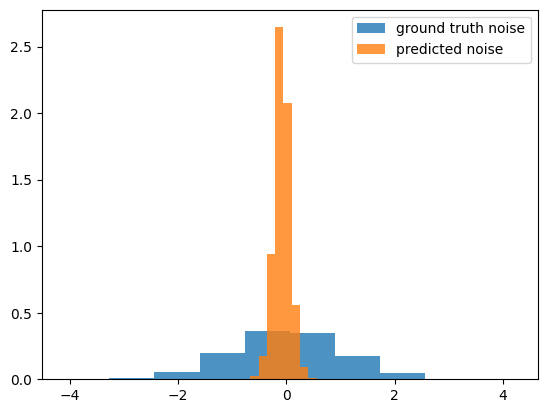

step 50: train loss 0.1487


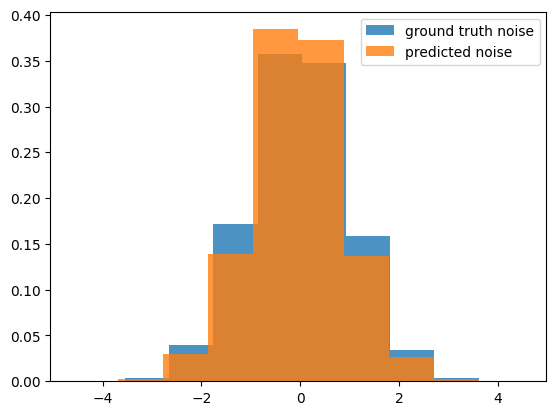

step 100: train loss 0.0624


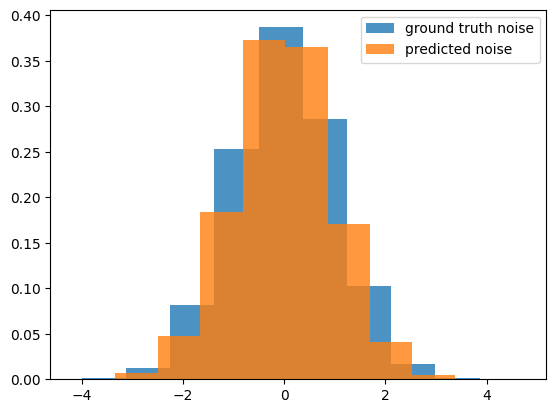

step 150: train loss 0.0394


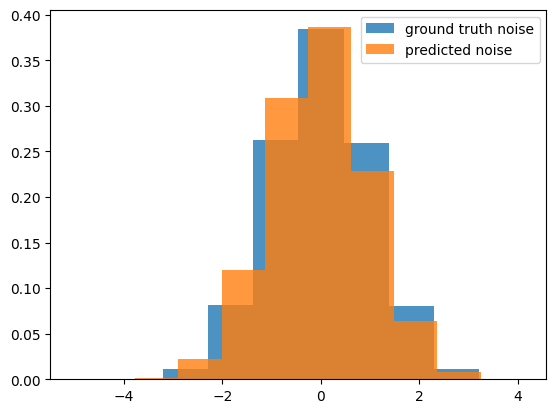

step 200: train loss 0.0394


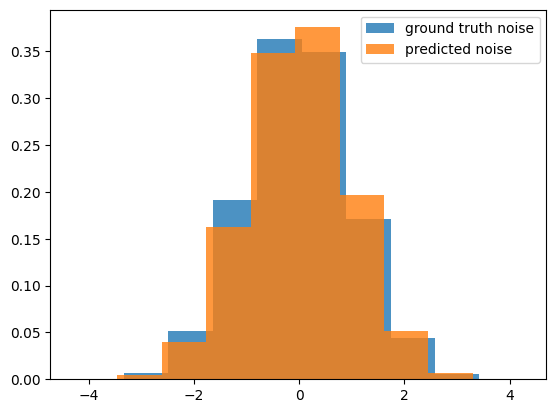

step 250: train loss 0.0256


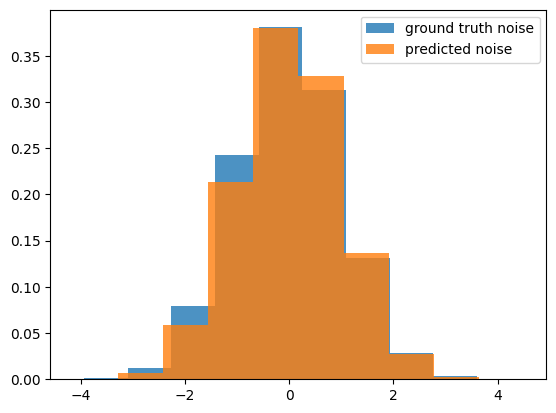

step 300: train loss 0.0252


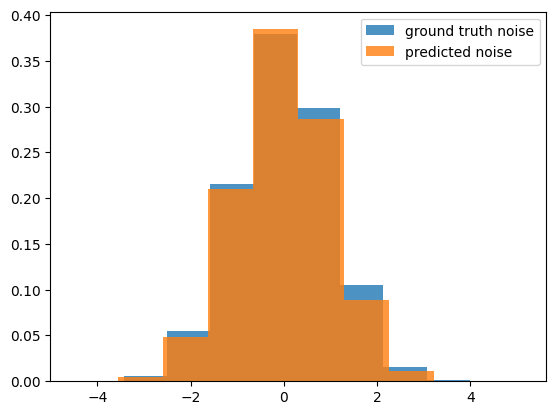

step 350: train loss 0.0269


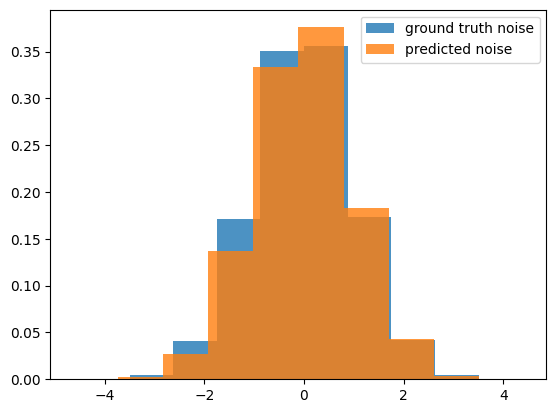

step 400: train loss 0.0190


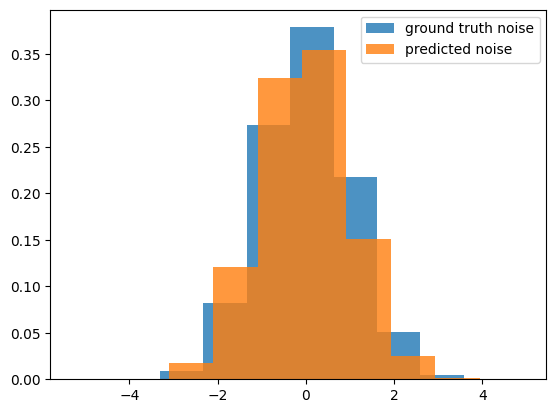

step 450: train loss 0.0154


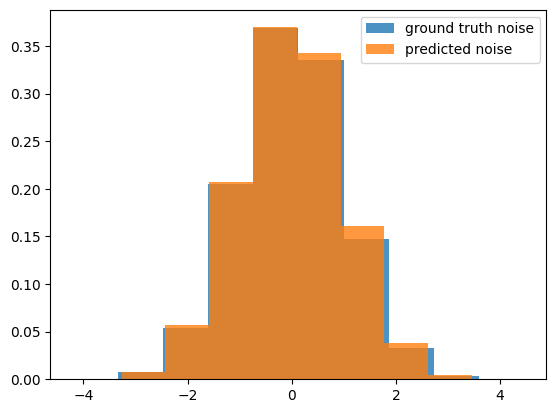

step 500: train loss 0.0155


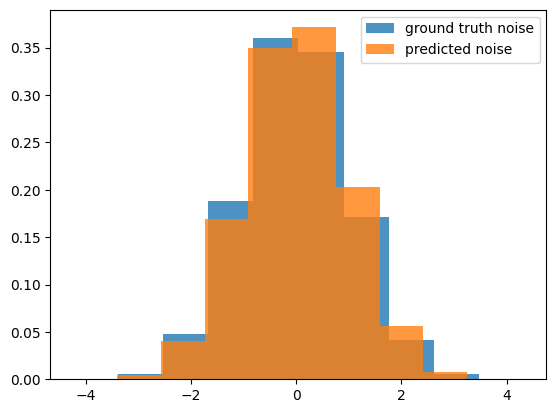

step 550: train loss 0.0156


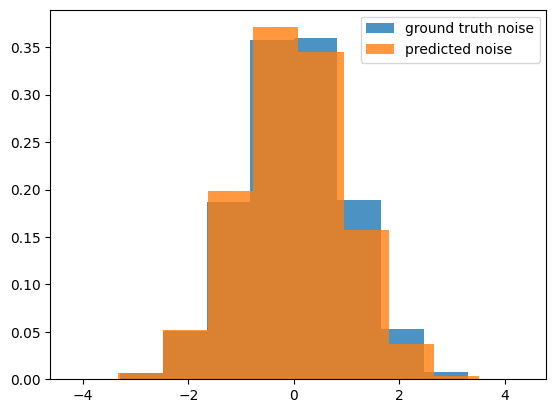

step 600: train loss 0.0115


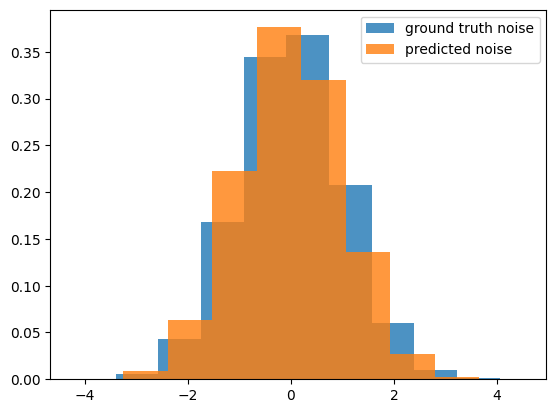

step 650: train loss 0.0107


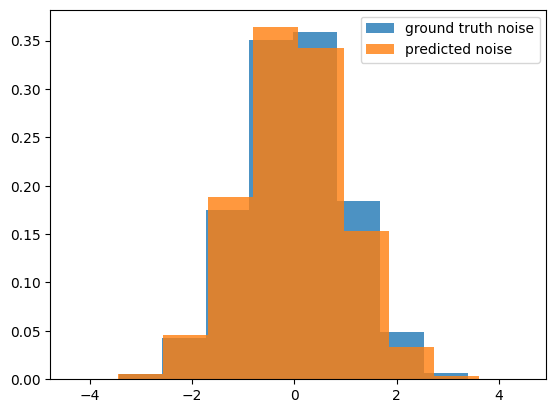

step 700: train loss 0.0156


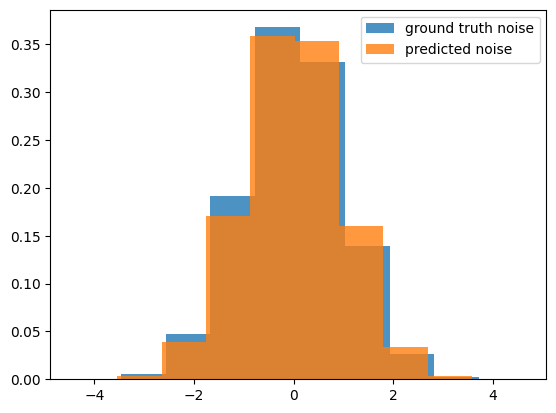

step 750: train loss 0.0102


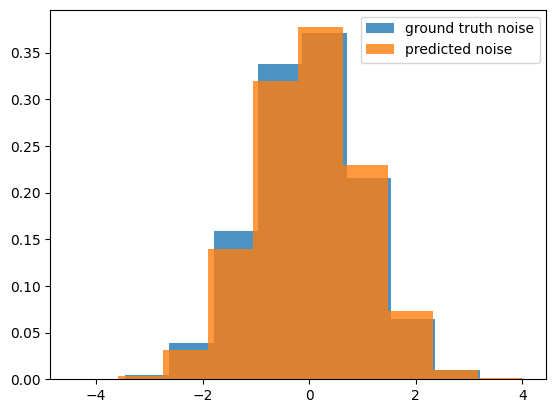

step 800: train loss 0.0090


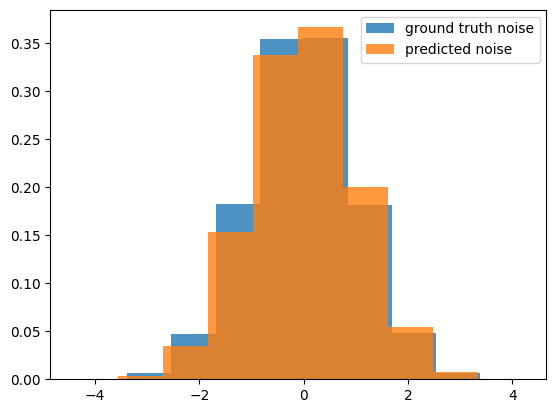

step 850: train loss 0.0106


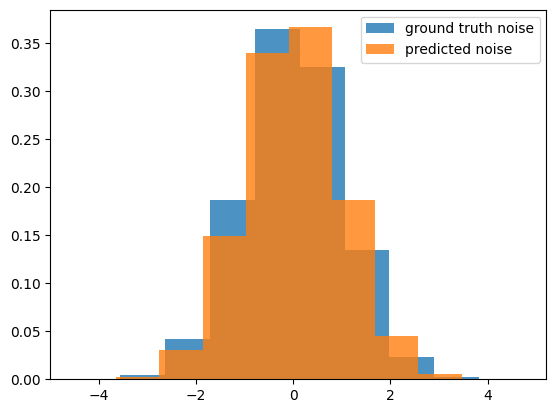

step 900: train loss 0.0089


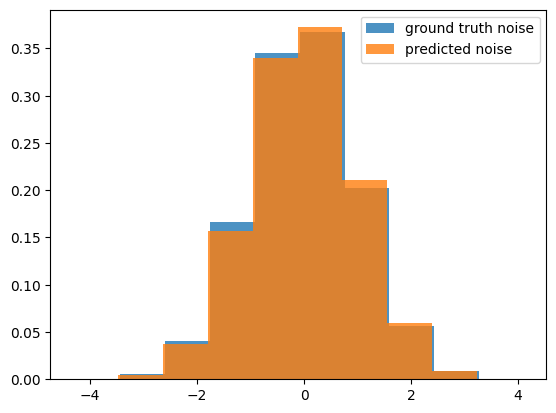

step 950: train loss 0.0103


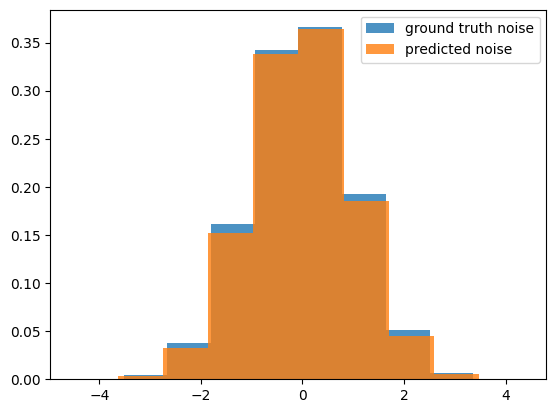

step 1000: train loss 0.0078


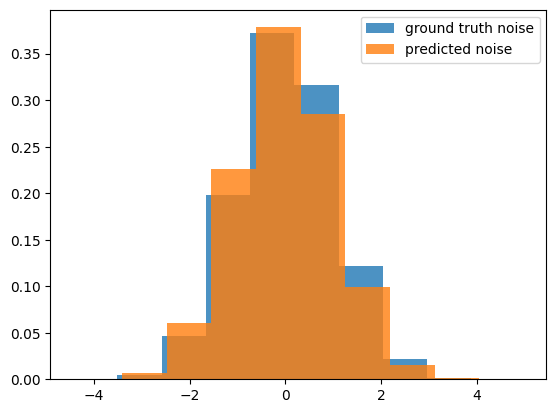

step 1050: train loss 0.0092


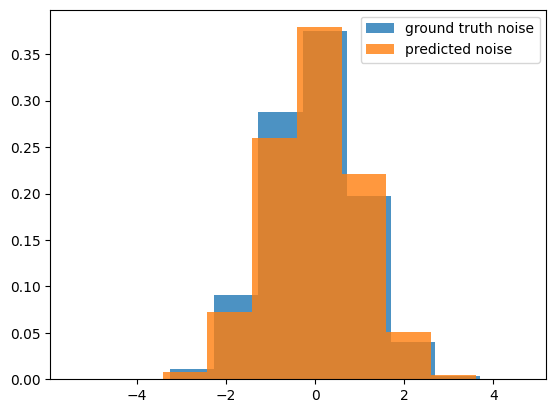

step 1100: train loss 0.0078


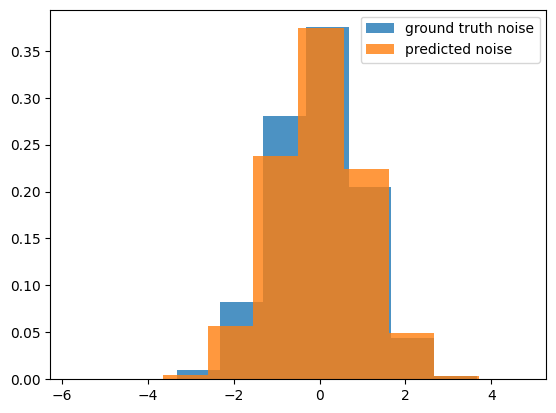

step 1150: train loss 0.0064


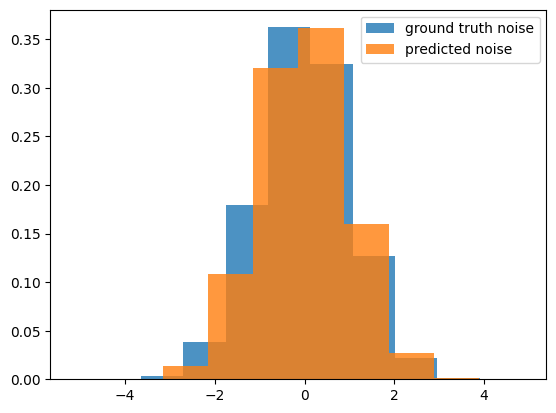

step 1200: train loss 0.0066


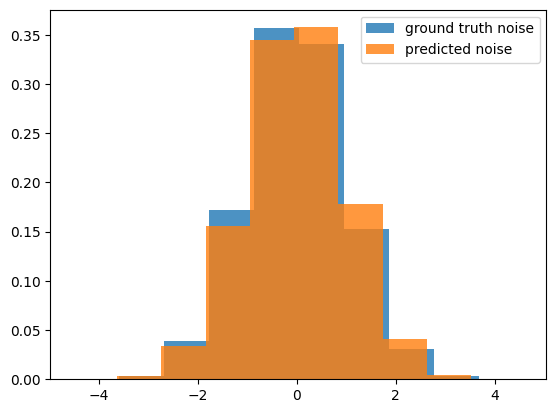

step 1250: train loss 0.0065


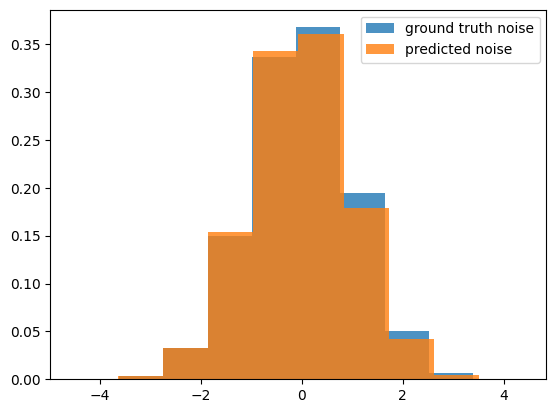

step 1300: train loss 0.0065


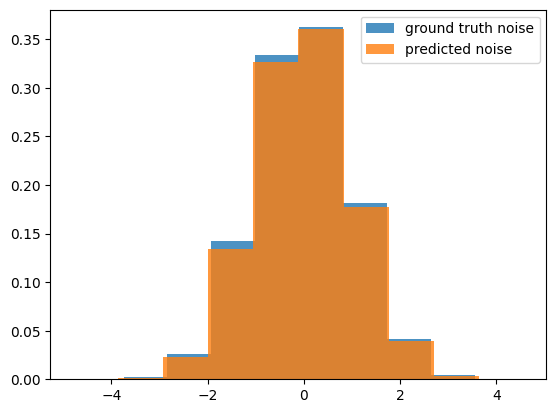

step 1350: train loss 0.0051


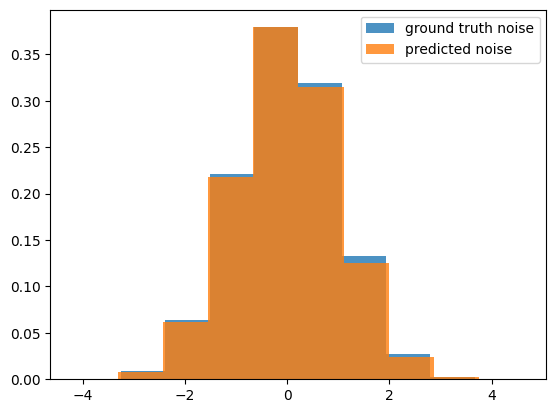

step 1400: train loss 0.0053


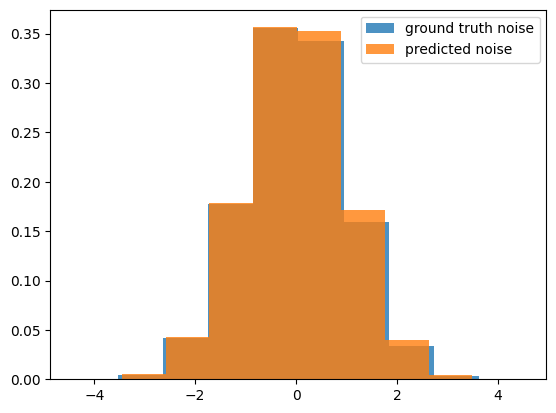

step 1450: train loss 0.0103


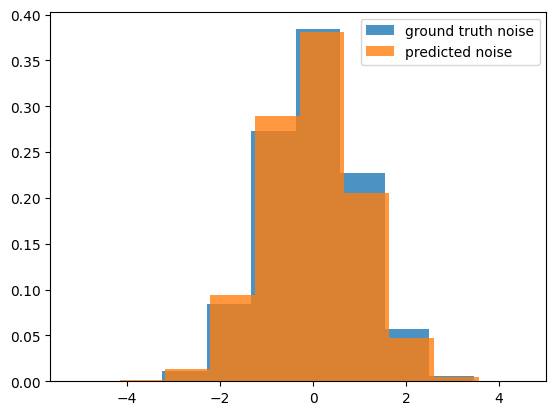

step 1500: train loss 0.0052


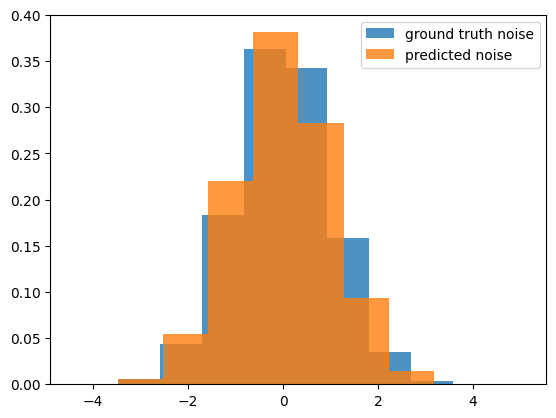

step 1550: train loss 0.0053


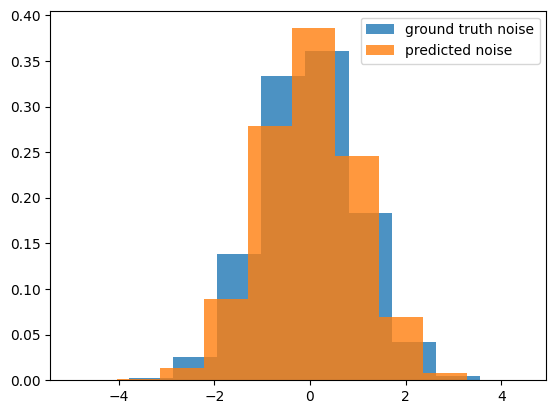

step 1600: train loss 0.0045


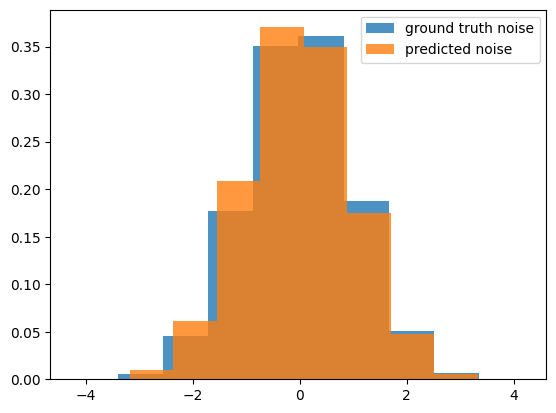

step 1650: train loss 0.0042


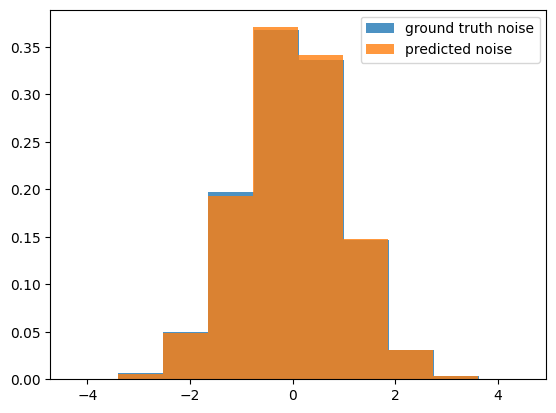

step 1700: train loss 0.0040


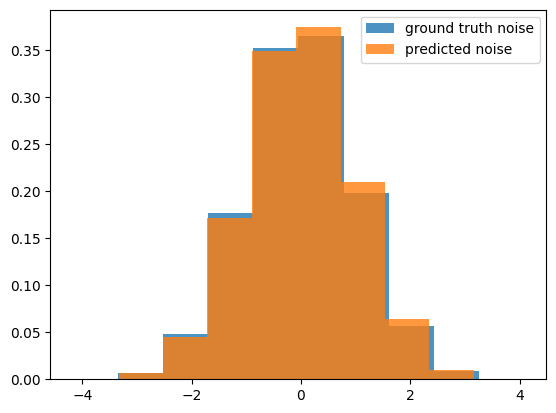

step 1750: train loss 0.0063


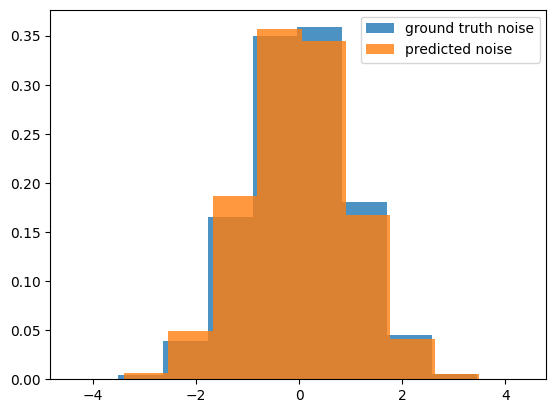

step 1800: train loss 0.0043


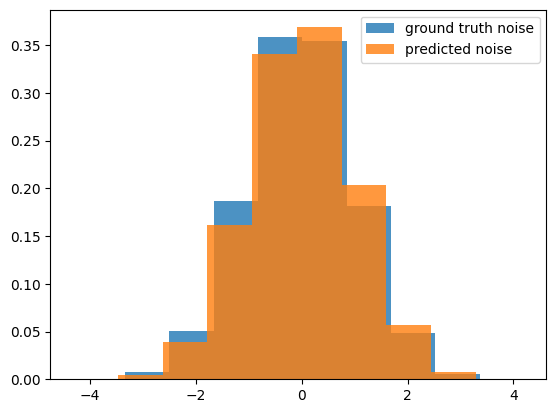

step 1850: train loss 0.0044


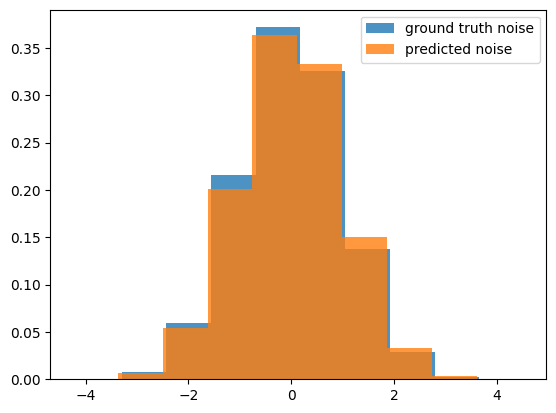

step 1900: train loss 0.0043


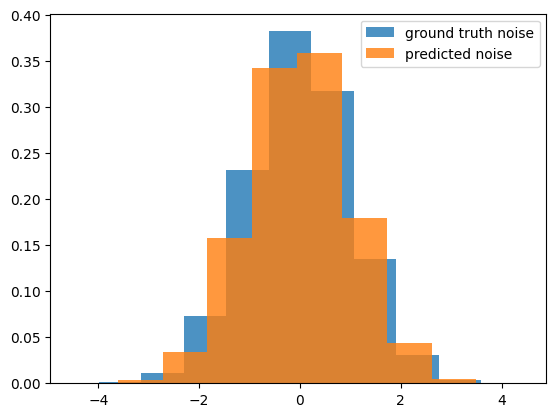

step 1950: train loss 0.0038


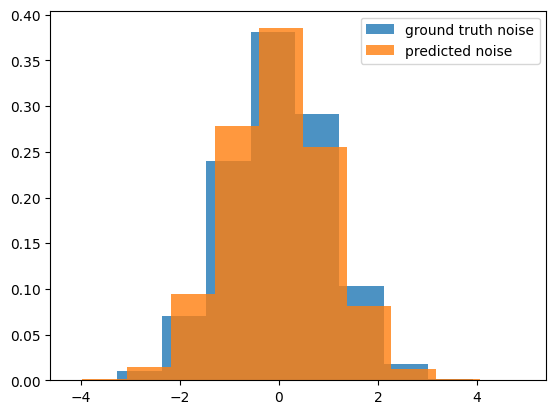

step 1999: train loss 0.0036


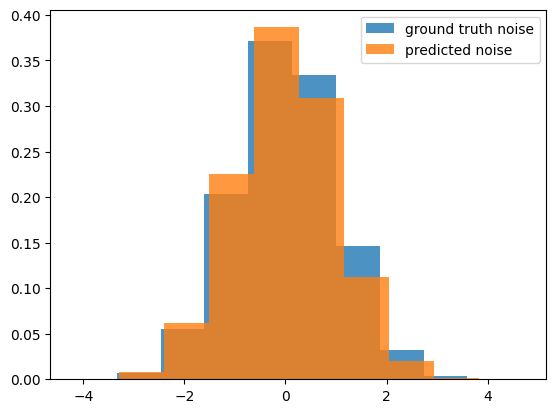

In [29]:
# -- Training

# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

# Training Loop
for i in range(max_iters):
    batch = torch.stack([images[0]] * batch_size).to(device)

    # Zero out the gradients
    optimizer.zero_grad()

    # Sample timesteps
    t = torch.randint(0, time_steps, (batch_size,)).long().to(device)

    # Detroy samples.
    # Shapes are (batch_size, num_channels, height, width) for both
    noisy_images, noise = model.destroy(batch, t, device)

    # Shape = (batch_size, num_channels, height, width)
    predicted_noise = unet(noisy_images, t)

    # Compute loss
    loss = torch.nn.functional.mse_loss(predicted_noise, noise)
    loss.backward()

    # Adjust weights
    optimizer.step()

    # Gather data report
    if i % eval_iters == 0 or i == max_iters - 1:
        print(f"step {i}: train loss {loss.item():.4f}")
        with torch.no_grad():
          plot_noise_distribution(noise, predicted_noise)


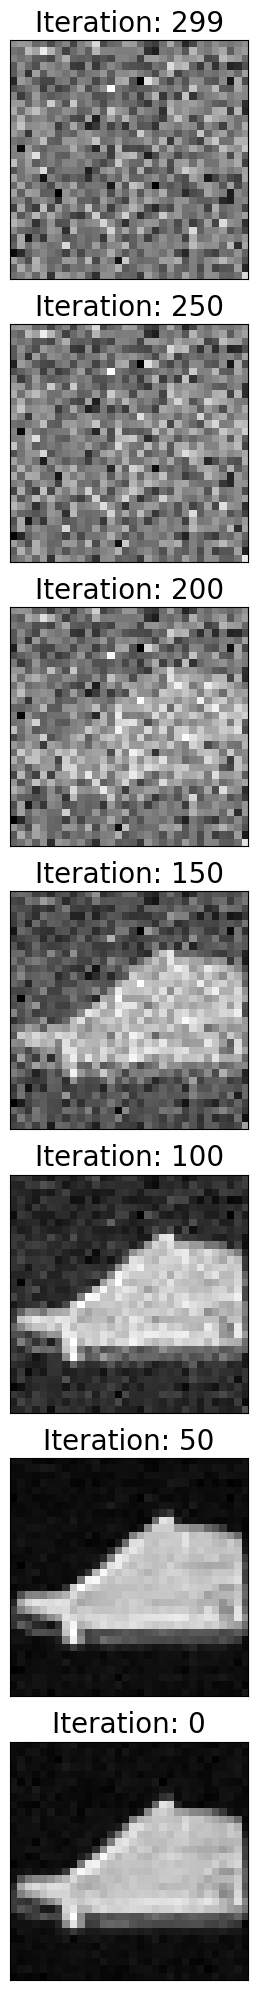

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

In [30]:
fig = plt.figure(figsize=(5, 20))
idx = 1

with torch.no_grad():
    batch = torch.randn_like(batch[0:1]).to(device)

    for i in reversed(range(time_steps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        batch = model.denoise(batch, t, unet.eval(), device)

        if i == time_steps - 1 or i % 50 == 0:
            plt.figure(figsize=(2,2))
            ax = fig.add_subplot(7, 1, idx, xticks=[], yticks=[])
            idx += 1

            ax.imshow(np.squeeze(batch[0].cpu()), cmap='gray')
            ax.set_title(f"Iteration: {i}", fontsize=20)
            fig.tight_layout()

In [31]:
# ------ Hyperparameters ------

# -- Data Breakdown
batch_size = 256

# -- Model Parameters
start_schedule = 0.001
end_schedule = 0.02
time_steps = 300

# -- Training Parameters
learning_rate = 0.001
num_epochs = 100
eval_iters = 5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [32]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [33]:
# -- Define Network
config_dict = {
    'start_schedule': start_schedule,
    'end_schedule': end_schedule,
    'time_steps': time_steps,
}

config = DiffusionConfig(**config_dict)
model = DiffusionModel(config)
unet = UNet(labels=True)

model = model.to(device)
unet = unet.to(device)

Epoch 0: train loss 0.0811


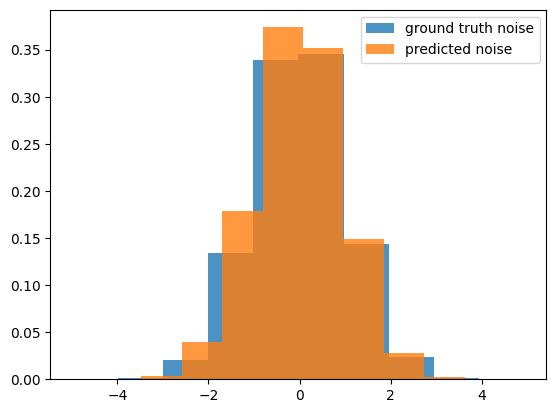

Epoch 5: train loss 0.0581


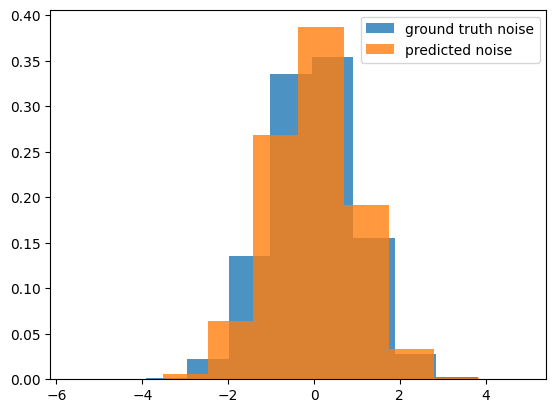

Epoch 10: train loss 0.0634


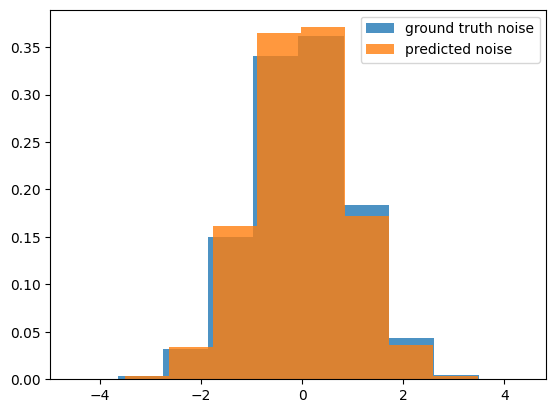

Epoch 15: train loss 0.0486


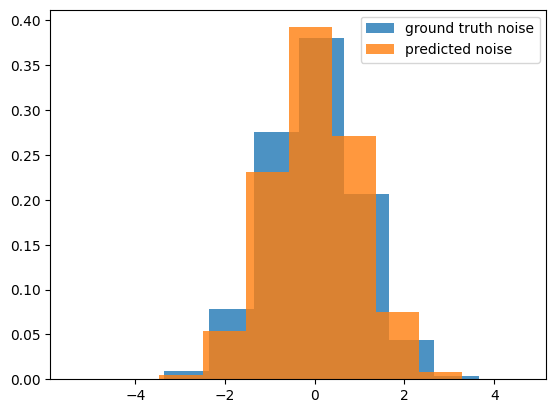

Epoch 20: train loss 0.0471


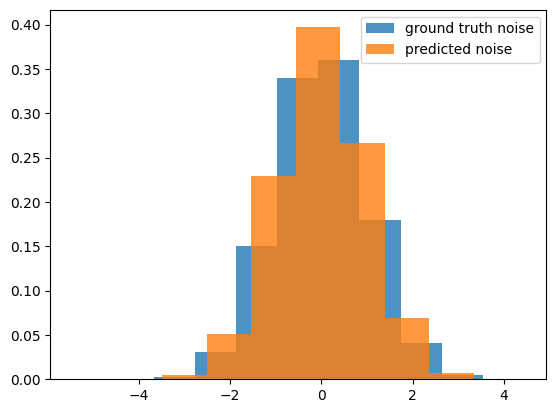

Epoch 25: train loss 0.0502


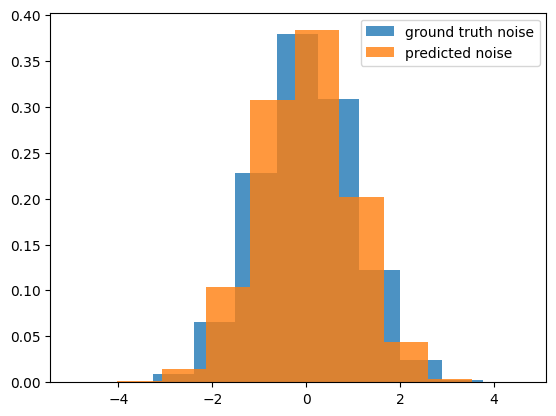

Epoch 30: train loss 0.0498


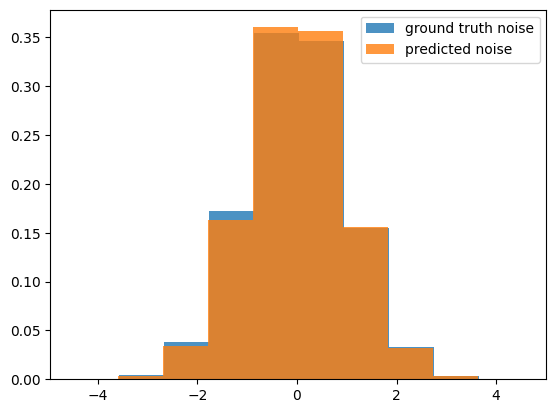

Epoch 35: train loss 0.0465


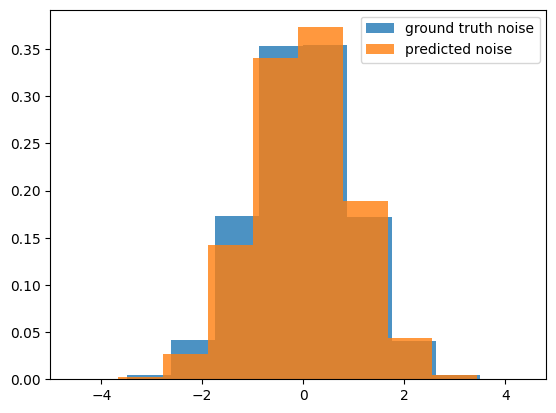

KeyboardInterrupt: ignored

In [35]:
# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch, label in dataloader:
      # Shape = (batch_size, C, H, W)
      batch, label = batch.to(device), label.to(device)

      # Zero out the gradients
      optimizer.zero_grad()

      # Sample timesteps
      t = torch.randint(0, time_steps, (batch_size,)).long().to(device)

      # Detroy samples.
      # Shapes are (batch_size, num_channels, height, width) for both
      noisy_images, noise = model.destroy(batch, t, device)

      # Shape = (batch_size, num_channels, height, width)
      predicted_noise = unet(noisy_images, t, labels = label.reshape(-1,1).float().to(device))

      # Compute loss
      loss = torch.nn.functional.mse_loss(predicted_noise, noise)
      loss.backward()

      # Adjust weights
      optimizer.step()

    # Gather data report
    if epoch % eval_iters == 0 or epoch == max_iters - 1:
        print(f"Epoch {epoch}: train loss {loss.item():.4f}")
        with torch.no_grad():
            # plot_noise_prediction(noise[0], predicted_noise[0])
            plot_noise_distribution(noise, predicted_noise)

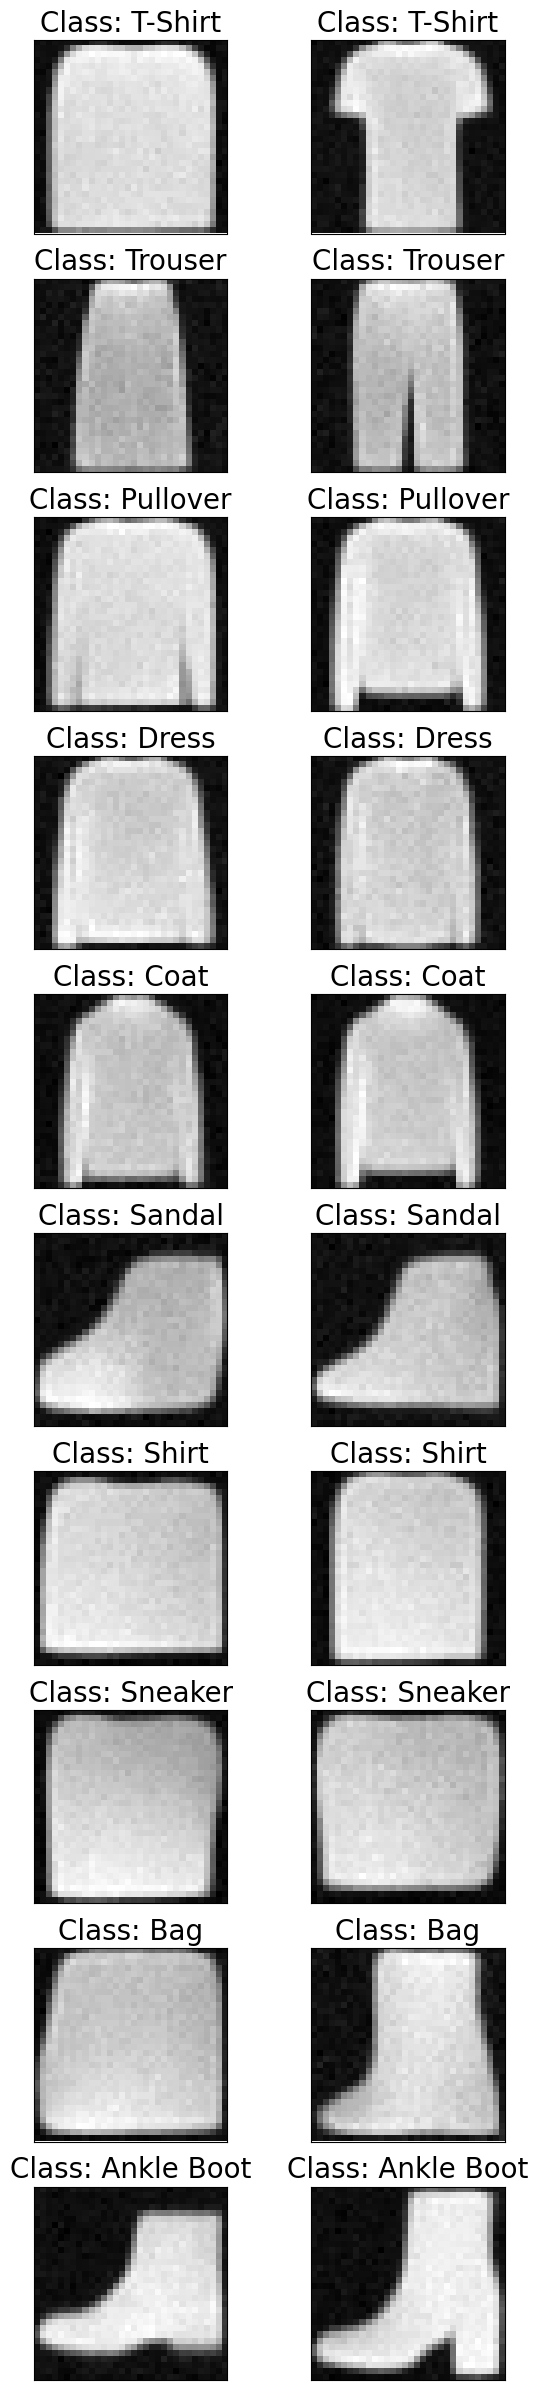

In [52]:
fig = plt.figure(figsize=(8, 24))
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

num_images_per_class = 2
sub_plot_index = 1
with torch.no_grad():
    for class_label in range(len(labels_map)):
      batch = torch.randn((num_images_per_class, 1, 32, 32)).to(device)

      for i in reversed(range(time_steps)):
          t = torch.full((num_images_per_class,), i, dtype=torch.long, device=device)
          labels = torch.tensor([class_label] * num_images_per_class).resize(num_images_per_class, 1).float().to(device)
          batch = model.denoise(batch, t, unet.eval(), device, labels = labels)

      for i in range(num_images_per_class):
          ax = fig.add_subplot(len(labels_map), num_images_per_class, sub_plot_index, xticks=[], yticks=[])
          sub_plot_index += 1
          ax.imshow(np.squeeze(batch[i].cpu()), cmap='gray')
          ax.set_title(f"Class: {labels_map[class_label]}", fontsize=20)
          fig.tight_layout()